# Clustering locations of traffic cameras in Hong Kong using Amazon SageMaker and the k-means algorithm

`bucket_name` is the name of the bucket to which SageMaker will write the trained model artifacts.
**Change this to a bucket that the notebook instance has permission to write to.**

In [22]:
bucket_name = 'traffic-cameras-k-means'

Let's install some packages we will need later.

In [23]:
!pip install --upgrade pip --quiet
!pip install geopandas --quiet
!pip install descartes --quiet
!pip install mxnet --quiet

Now we load the traffic camera location data. The original source of the data is [here](https://data.gov.hk/en-data/dataset/hk-td-tis_2-traffic-snapshot-images/resource/338f29cd-cefc-49b9-b2d2-2894cb28953f); note that I had to re-save the data as UTF-8 so that pandas can read it without errors.

In [24]:
import pandas as pd

cameras = pd.read_csv('Traffic_Camera_Locations_En.csv')
cameras.head()

,key,region,description,easting,northing,latitude,longitude,url
0,H429F,Hong Kong Island,Aberdeen Praya Road near Fish Market,833514,812196,22.248525,114.150158,http://tdcctv.data.one.gov.hk/H429F.JPG
1,H210F,Hong Kong Island,Aberdeen Tunnel - Wan Chai Side,836504,815117,22.274906,114.179164,http://tdcctv.data.one.gov.hk/H210F.JPG
2,H421F,Hong Kong Island,Aberdeen Tunnel - Aberdeen Side,836245,812386,22.250244,114.176651,http://tdcctv.data.one.gov.hk/H421F.JPG
3,H422F2,Hong Kong Island,Ap Lei Chau Bridge Road near Aberdeen Police S...,834632,812129,22.247922,114.161003,http://tdcctv.data.one.gov.hk/H422F2.JPG
4,H904F,Hong Kong Island,Canal Road Flyover near Gloucester Road,836731,815614,22.279394,114.181367,http://tdcctv.data.one.gov.hk/H904F.JPG


## Training the model

We can use the high-level SageMaker Python SDK to create a *estimator* to train the model. Note that we are specifying that we want 15 clusters (`k=15`).

In [25]:
from sagemaker import KMeans, get_execution_role

kmeans = KMeans(role=get_execution_role(),
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://' + bucket_name + '/',
                k=15)

We only need the **latitude** and **longitude** columns for the k-means model, so let's pull these off into a new
DataFrame.

In [26]:
train_df = cameras[['latitude', 'longitude']]

Now we need to convert this to a numpy `ndarray`. Also, pandas will have loaded these as **float64** values, so we
need to convert them to **float32**s, which is what the SageMaker training algorithm requires.

In [27]:
train_data = train_df.values.astype('float32')

We should generate our own unique name for the training job rather than letting SageMaker assign one, so that we
can locate the generated model artifacts later.

In [28]:
from datetime import datetime

job_name = 'traffic-cameras-k-means-job-{}'.format(datetime.now().strftime("%Y%m%d%H%M%S"))

Now we can train the model. The SDK makes this easy, but there's a lot going on behind the scenes.

* The SDK writes our training data to a SageMaker S3 bucket in Protocol Buffers format.
* SageMaker spins up one or more containers to run the training algorithm.
* The containers read the training data from S3, and use it to create the number of clusters specified.
* SageMaker writes artifacts for the trained model to the location specified by `output_path` above, using an
  MXNet serialisation format, then shuts down the containers.

The process takes several minutes.

In [29]:
%%time
kmeans.fit(kmeans.record_set(train_data), job_name=job_name)

2019-08-17 14:16:19 Starting - Starting the training job...
2019-08-17 14:16:21 Starting - Launching requested ML instances...
2019-08-17 14:17:20 Starting - Preparing the instances for training.........
2019-08-17 14:18:38 Downloading - Downloading input data...
2019-08-17 14:19:18 Training - Training image download completed. Training in progress.
2019-08-17 14:19:18 Uploading - Uploading generated training model
Docker entrypoint called with argument(s): train
[08/17/2019 14:19:16 INFO 140386360764224] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'f

## Interpreting the model

While the SageMaker Python SDK makes it straightforward to train the model, interpreting the model (i.e.
finding the cluster centroids) requires more work.

SageMaker stores the model artifacts in S3 in the location we specify, so the first step is to download the model
artifacts to the notebook instance.

In [31]:
import boto3

model_key = job_name + '/output/model.tar.gz'
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

Next, we extract and unzip the model artifacts.

In [33]:
import os

os.system('tar -zxvf model.tar.gz')

0

In [35]:
os.system('unzip model_algo-1')

2304

Then we can use the MXNet libraries to load the model data into a numpy `ndarray`.

In [38]:
import mxnet as mx

Kmeans_model_params = mx.ndarray.load('model_algo-1')

Next we turn this into a pandas DataFrame with appropriate column names.

In [ ]:
cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns = train_df.columns

## Visualising the results

Now we can use GeoPandas to visualise the results. Red dots show the camera locations, blue triangles show the cluster centroids. For more on mapping geolocation data using GeoPandas, see
[this notebook](https://github.com/rmlowe/traffic-cameras-geopandas/blob/master/Traffic%20Cameras%20-%20GeoPandas.ipynb).

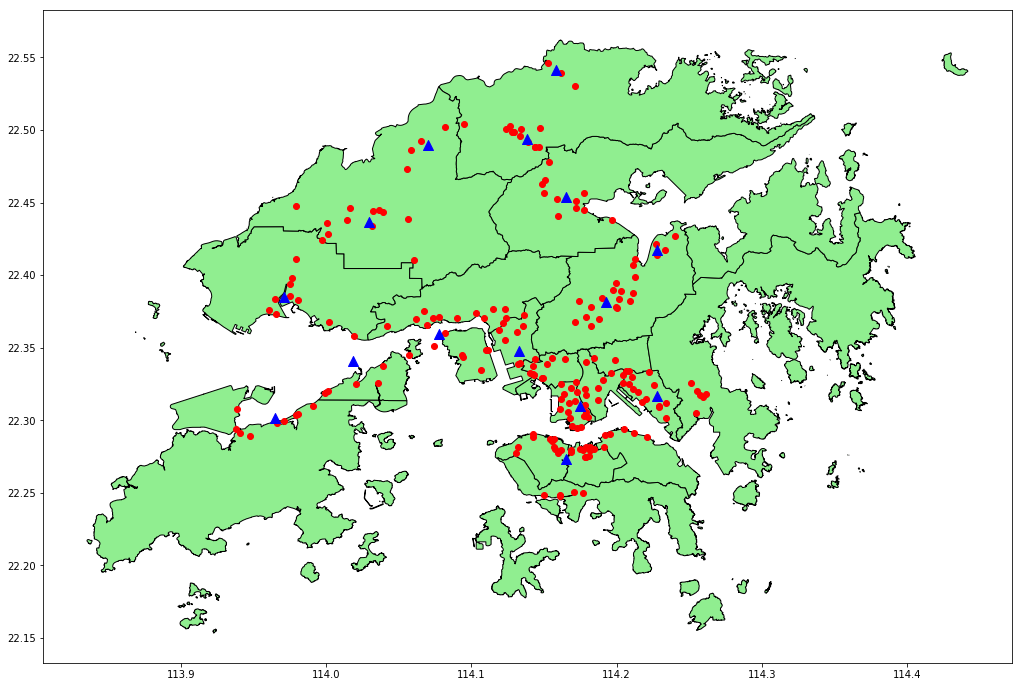

In [47]:
from geopandas import GeoDataFrame, points_from_xy
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [19, 12]

hong_kong = GeoDataFrame.from_file('Hong_Kong_18_Districts/')
cameras_geo = GeoDataFrame(cameras, geometry=points_from_xy(cameras.longitude, cameras.latitude))
centroids_geo = GeoDataFrame(
    cluster_centroids, geometry=points_from_xy(cluster_centroids.longitude, cluster_centroids.latitude))
axes = hong_kong.plot(color='lightgreen', edgecolor='black')
cameras_geo.plot(ax=axes, color='red')
centroids_geo.plot(ax=axes, marker='^', color='blue', markersize=100)